In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax

import icomo


sys.path.append("../")
from testing_artefacts_pharmaco_multipath import model_STI
from testing_artefacts_pharmaco_multipath import sti_infection_results_H

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model

In [2]:
# Arguments for the model
args = {
    "beta_HIV": 0.6341 / 360.0,  # HIV infection rate per day
    "beta_STI": 0.0016 * 5.0,  # STI infection rate
    "mu": 1.0 / 45.0 / 360.0,  # Natural death rate per day
    "gamma_STI": 1.0 / 1.32 / 360.0,  # Recovery rate from asymptomatic STI per day
    "gammaT_STI": 1.0 / 14.0,  # Recovery rate from treated STI per day
    "lambda_0_a": 0.0,  # Baseline test rate for asymptomatic STI
    "lambda_0": 0.3 / 11.0,  # Baseline test rate for symptomatic STI
    "lambda_P": 1 / 3 / 360,  # Infection rate due to HIV prevalence
    "asymptomatic": 0.9,  # Proportion of asymptomatic infections
    "m_max": 0.8,  # Maximum modulating factor
    "H_thres": 0.1,  # HIV threshold
    "m_eps": 0.01,  # Small constant for smoothing
    "Phi_r": 40.0,  # Not used in the current model
    "H_tau": 20.0,  # Not used in the current model
    "c": 50.0,  # Scaling factor for HIV interaction term
    "H": 0.0,  # Initial HIV prevalence
    "P_HIV": 0.0,  # Initial proportion of HIV positive individuals
}
# Initial state of the compartments
y0 = {
    "S_STI": 0.99,  # Initial susceptible proportion
    "Ia_STI": 0.009,  # Initial asymptomatic proportion
    "Is_STI": 0.001,  # Initial symptomatic proportion
    "T_STI": 0.0,  # Initial treated proportion
}
integrator = model_STI.setup_model(args, y0)

INFO:testing_artefacts_pharmaco_multipath.STI.model_STI:Model setup complete and ready for simulation


## Sweep

## Ps, Lambda_P are continuous from 0 to 1 and 0.1 to 6 respectively. Hs with 8 discrete values (Log/linear scale)

In [3]:
# Define the ranges for lambda_P (proportional infection rate due to HIV prevalence) and P (proportion of HIV positive individuals)
lambda_P_values = np.linspace(
    0.1 / 360, 6 / 360, 60
)  # 101 points from 0.1/360 to 6/360
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0

# Define the discrete values for H (HIV prevalence)
# Hs = np.linspace(0, 0.2, 8)  # 8 discrete values from 0 to 0.2
Hs = np.logspace(-3, -0.698, 8)  # 8 discrete values from 0.001 to 0.2

In [ ]:
results = sti_infection_results_H.compute_sti_infections(
    Hs,
    Ps,
    lambda_P_values,
    y0,
    args,
    integrator,
    model_STI,
    filename="results_discrete_H_log_from_0.1",
)

# Figures

## Endemic new infetions (Real Infections)

<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_12304\3477428039.py:67: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_P$ (per year)")


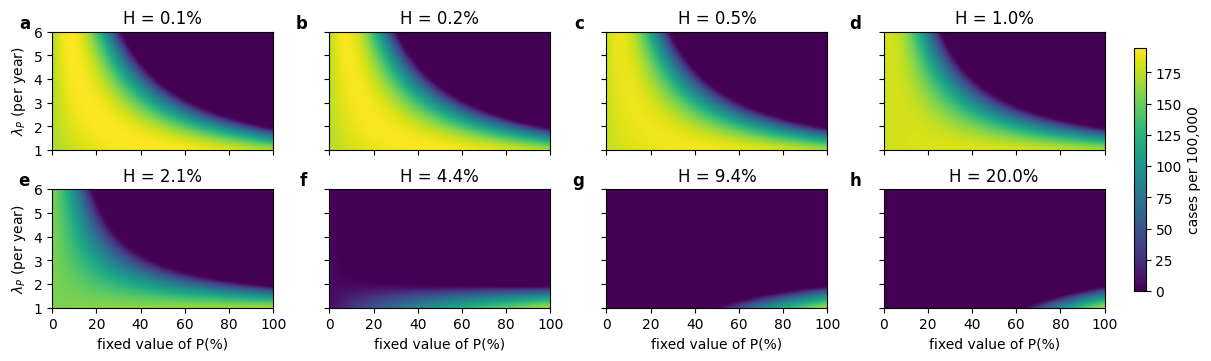

In [8]:
# Load the results from the file
# results = np.load("../results/results_discrete_H.npy", allow_pickle=True).item()
results = np.load("../results/results_discrete_H_log.npy", allow_pickle=True).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate([results[H]["res_infections"].flatten() for H in Hs])

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

num_H = len(Hs)

# Set up the figure and axes
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_H // 2,
    figsize=(3 * num_H // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, H in enumerate(Hs):
    ax = axes.flat[idx]
    res_infections = results[H]["res_infections"]
    cax = ax.imshow(
        res_infections,
        origin="lower",
        aspect="auto",
        vmin=global_vmin,
        vmax=global_vmax,
        extent=[0, 100, 1 / 360, 6 / 360],
    )
    ax.set_title(f"H = {H * 100:.1f}%")

    # Set xlabels only on the bottom most subplots
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 20, 40, 60, 80, 100])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[40] * 100),
                int(Ps[80] * 100),
                int(Ps[120] * 100),
                int(Ps[160] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if idx % ncols == 0:
        ax.set_ylabel("$\lambda_P$ (per year)")
        ax.set_yticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
        ax.set_yticklabels(["1", "2", "3", "4", "5", "6"])
    else:
        ax.set_yticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.15,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()

## Cases vs $\lambda_P$ for different H values(P=average)

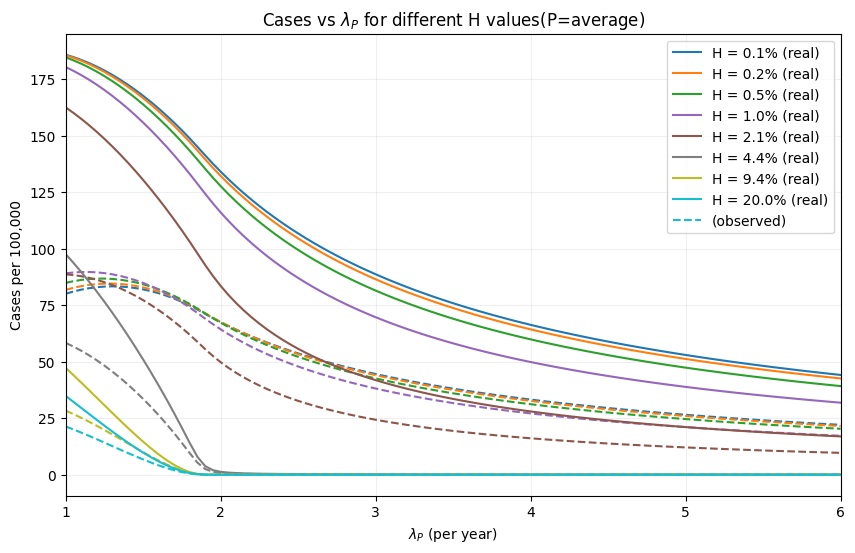

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from itertools import cycle

# Load the results from the file
Hs = np.logspace(-3, -0.698, 8)
results = np.load("../results/results_discrete_H_log.npy", allow_pickle=True).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax for infections
all_infections = np.concatenate([results[H]["res_infections"].flatten() for H in Hs])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define line styles for infections and tests
line_styles = {"infections": "-", "tests": "--"}

# Define a color cycle
colors = cycle(plt.cm.tab10(np.linspace(0, 1, len(Hs))))

for H in Hs:
    color = next(colors)
    res_infections = results[H]["res_infections"]
    res_tests = results[H]["res_tests"]
    lambda_P = np.linspace(1 / 360, 6 / 360, res_infections.shape[0])

    cases_infections = res_infections.mean(axis=1)  # Averaging over all P values
    cases_tests = res_tests.mean(axis=1)  # Averaging over all P values

    ax.plot(
        lambda_P,
        cases_infections,
        label=f"H = {H * 100:.1f}% (real)",
        linestyle=line_styles["infections"],
        color=color,
    )
    ax.plot(
        lambda_P,
        cases_tests,
        linestyle=line_styles["tests"],
        color=color,
    )
# Add a custom legend entry for the observed data
ax.plot([], [], linestyle=line_styles["tests"], color=color, label="(observed)")

ax.set_xlabel("$\\lambda_P$ (per year)")
ax.set_ylabel("Cases per 100,000")
ax.set_xticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
ax.set_xticklabels(["1", "2", "3", "4", "5", "6"])
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend()
ax.set_title("Cases vs $\\lambda_P$ for different H values(P=average)")
ax.set_xlim([1 / 360, 6 / 360])


plt.grid(alpha=0.2)
plt.show()

## Cases vs $\lambda_P$ for different H values(P=80%)

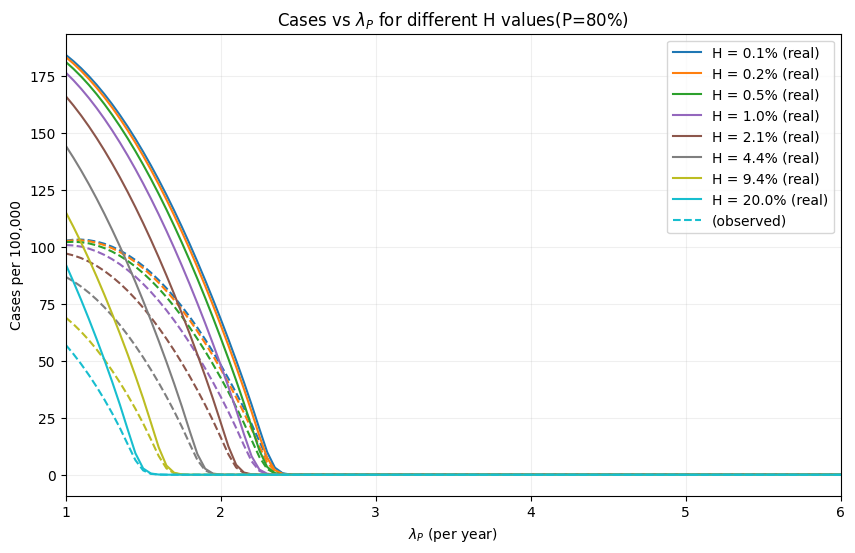

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from itertools import cycle

# Load the results from the file
Hs = np.logspace(-3, -0.698, 8)
results = np.load("../results/results_discrete_H_log.npy", allow_pickle=True).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax for infections
all_infections = np.concatenate([results[H]["res_infections"].flatten() for H in Hs])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define line styles for infections and tests
line_styles = {"infections": "-", "tests": "--"}

# Define a color cycle
colors = cycle(plt.cm.tab10(np.linspace(0, 1, len(Hs))))
P_value = 0.8
# P values are in the range [0, 1] and evenly spaced
P_values = np.linspace(0, 1, results[Hs[0]]["res_infections"].shape[1])
P_index = np.argmin(np.abs(P_values - P_value))

for H in Hs:
    color = next(colors)
    res_infections = results[H]["res_infections"]
    res_tests = results[H]["res_tests"]
    lambda_P = np.linspace(1 / 360, 6 / 360, res_infections.shape[0])

    cases_infections = res_infections[:, P_index]  # Values for P = 0.8
    cases_tests = res_tests[:, P_index]  # Values for P = 0.8

    ax.plot(
        lambda_P,
        cases_infections,
        label=f"H = {H * 100:.1f}% (real)",
        linestyle=line_styles["infections"],
        color=color,
    )
    ax.plot(
        lambda_P,
        cases_tests,
        linestyle=line_styles["tests"],
        color=color,
    )
# Add a custom legend entry for the observed data
ax.plot([], [], linestyle=line_styles["tests"], color=color, label="(observed)")

ax.set_xlabel("$\\lambda_P$ (per year)")
ax.set_ylabel("Cases per 100,000")
ax.set_xticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
ax.set_xticklabels(["1", "2", "3", "4", "5", "6"])
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend()
ax.set_title(f"Cases vs $\\lambda_P$ for different H values(P={P_value*100:.0f}%)")
ax.set_xlim([1 / 360, 6 / 360])


plt.grid(alpha=0.2)
plt.show()

## Cases vs $\lambda_P$ for different H values (P=60,80)

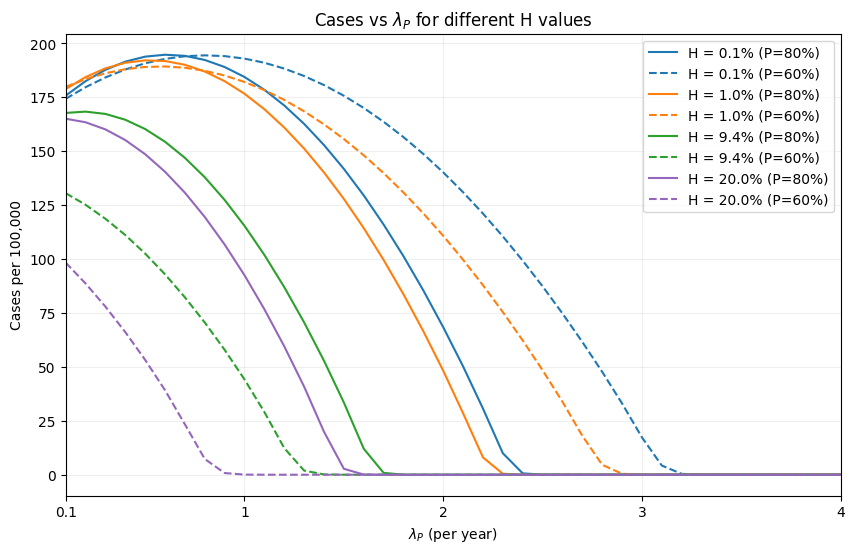

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from itertools import cycle

# Load the results from the file
Hs = np.logspace(-3, -0.698, 8)
results = np.load(
    "../results/results_discrete_H_log_from_0.1.npy", allow_pickle=True
).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax for infections
all_infections = np.concatenate([results[H]["res_infections"].flatten() for H in Hs])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define line styles for infections
line_styles = {"P1": "-", "P2": "--"}

# Define a color cycle
colors = cycle(plt.cm.tab10(np.linspace(0, 1, len(Hs))))

# Define the P values to plot
P_values_to_plot = [0.8, 0.6]

# P values are in the range [0, 1] and evenly spaced
P_values = np.linspace(0, 1, results[Hs[0]]["res_infections"].shape[1])
P_indices = [np.argmin(np.abs(P_values - P)) for P in P_values_to_plot]

# Indices of Hs to plot
indices_to_plot = [0, 3, 6, 7]

for idx in indices_to_plot:
    H = Hs[idx]
    color = next(colors)
    res_infections = results[H]["res_infections"]
    lambda_P = np.linspace(0.1 / 360, 6 / 360, res_infections.shape[0])

    for i, P_index in enumerate(P_indices):
        cases_infections = res_infections[:, P_index]  # Values for the specific P
        linestyle = line_styles[f"P{i+1}"]
        ax.plot(
            lambda_P,
            cases_infections,
            label=f"H = {H * 100:.1f}% (P={P_values_to_plot[i]*100:.0f}%)",
            linestyle=linestyle,
            color=color,
        )

ax.set_xlabel("$\\lambda_P$ (per year)")
ax.set_ylabel("Cases per 100,000")
ax.set_xticks([0.1 / 360, 1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
ax.set_xticklabels(["0.1", "1", "2", "3", "4", "5", "6"])
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend()
ax.set_title("Cases vs $\\lambda_P$ for different H values")
ax.set_xlim([0.1 / 360, 4 / 360])

plt.grid(alpha=0.2)
plt.show()

# fig.savefig("../figures/IvslambdaP.pdf", format="pdf")

## Cases vs $\lambda_P$ for different H and P values

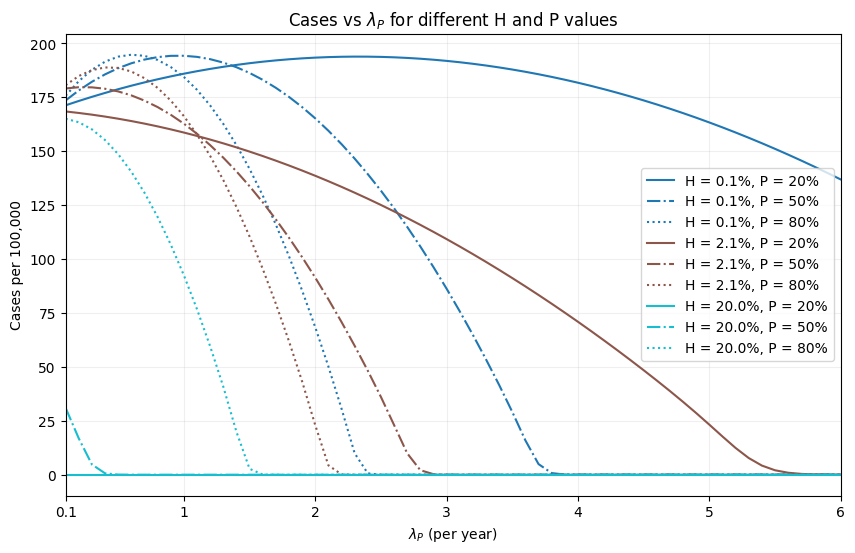

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from itertools import cycle

# Load the results from the file
results = np.load(
    "../results/results_discrete_H_log_from_0.1.npy", allow_pickle=True
).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Define the H and P values to plot
Hs_to_plot = [0.001, 0.01, 0.1]  # Example H values
P_values_to_plot = [0.2, 0.5, 0.8]  # Example P values

# P values are in the range [0, 1] and evenly spaced
P_values = np.linspace(0, 1, results[Hs_to_plot[0]]["res_infections"].shape[1])
P_indices = [np.argmin(np.abs(P_values - P)) for P in P_values_to_plot]

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define a color cycle
colors = cycle(plt.cm.tab10(np.linspace(0, 1, len(Hs_to_plot))))

# Define line styles
line_styles = cycle(["-", "-.", ":"])

indices_to_plot = [0, 4, 7]

for idx in indices_to_plot:
    H = Hs[idx]
    color = next(colors)
    res_infections = results[H]["res_infections"]
    lambda_P = np.linspace(0.1 / 360, 6 / 360, res_infections.shape[0])

    for i, P_index in enumerate(P_indices):
        cases_infections = res_infections[:, P_index]  # Values for the specific P
        linestyle = next(line_styles)
        ax.plot(
            lambda_P,
            cases_infections,
            label=f"H = {H * 100:.1f}%, P = {P_values_to_plot[i] * 100:.0f}%",
            linestyle=linestyle,
            color=color,
        )

ax.set_xlabel("$\\lambda_P$ (per year)")
ax.set_ylabel("Cases per 100,000")
ax.set_xticks([0.1 / 360, 1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
ax.set_xticklabels(["0.1", "1", "2", "3", "4", "5", "6"])
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend()
ax.set_title("Cases vs $\\lambda_P$ for different H and P values")
ax.set_xlim([0.1 / 360, 6 / 360])

plt.grid(alpha=0.2)
plt.show()

## $\frac{\Delta \text{Cases}}{\Delta P}$ vs P for different H and $\lambda_P$ values

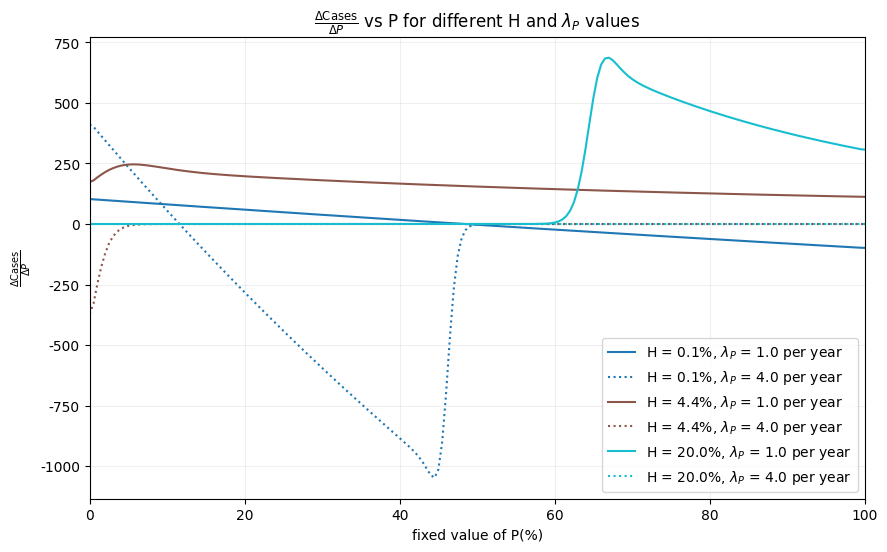

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from itertools import cycle

# Load the results from the file
results = np.load(
    "../results/results_discrete_H_log_from_0.1.npy", allow_pickle=True
).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Define the H and lambda_P values to plot
Hs_to_plot = [0.001, 0.01, 0.1]  # Example H values
lambda_P_values_to_plot = [1 / 360, 4 / 360]

# P values are in the range [0, 1] and evenly spaced
P_values = np.linspace(0, 1, results[Hs_to_plot[0]]["res_infections"].shape[1])

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define a color cycle
colors = cycle(plt.cm.tab10(np.linspace(0, 1, len(Hs_to_plot))))

# Define line styles
line_styles = cycle(["-", ":"])

indices_to_plot = [0, 5, 7]

for idx in indices_to_plot:
    H = Hs[idx]
    color = next(colors)
    res_infections = results[H]["res_infections"]
    lambda_P = np.linspace(0.1 / 360, 6 / 360, res_infections.shape[0])

    for lambda_P_value in lambda_P_values_to_plot:
        lambda_P_index = np.argmin(np.abs(lambda_P - lambda_P_value))
        infections_at_lambda_P = res_infections[lambda_P_index, :]

        # Calculate the derivative with respect to P
        del_infections_del_P = np.gradient(infections_at_lambda_P, P_values)

        linestyle = next(line_styles)
        ax.plot(
            P_values,
            del_infections_del_P,
            label=f"H = {H * 100:.1f}%, $\\lambda_P$ = {lambda_P_value * 360:.1f} per year",
            linestyle=linestyle,
            color=color,
        )

ax.set_xlabel("fixed value of P(%)")
ax.set_xticks([0, 0.20, 0.40, 0.60, 0.80, 1.00])
ax.set_xticklabels(
    [
        int(Ps[0] * 100),
        int(Ps[40] * 100),
        int(Ps[80] * 100),
        int(Ps[120] * 100),
        int(Ps[160] * 100),
        int(Ps[200] * 100),
    ]
)
ax.set_ylabel(r"$\frac{\Delta \text{Cases}}{\Delta P}$")
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend()
ax.set_title(
    r"$\frac{\Delta \text{Cases}}{\Delta P}$ vs P for different H and $\lambda_P$ values"
)
ax.set_xlim([0, 1])
plt.grid(alpha=0.2)
plt.show()

# fig.savefig("../figures/delI_delP.pdf", format="pdf")